In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn import GRNMain
from lib.sde.mutate import SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time
from jf.utils.helper import provide_id

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
_MUTATE_FUNC = SparseMutator()

In [4]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(7, 5, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    return sol

In [5]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [6]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 10000 - 1 * delta_late - 0.5 * delta_early)

In [7]:
def hook_event_handler(cell_program):
    # prob **2 and **4
    q = np.array(cell_program.quantities)
    if random() < (q[0] / 2)**4:  # missing a reset
        cell_program.quantities = cell_program.quantities.at[0].set(0)
        return Action.Divide, GRNCell.Progenitor
    
    if random() < (q[1] / 2)**1.5 * (1 - q[2] / 2)**1.5:
        return Action.DiffNeuron, GRNCell.PostMitoticInfra
    
    if random() < (q[2] / 2)**1.5 * (1 - q[1] / 2)**1.5:
        return Action.DiffNeuron, GRNCell.PostMitoticSupra
    
    return Action.NoOp, None

In [8]:
def get_bb(prun, grn):
    from submodels.grn_auto_v1 import GRNCell
    ccls = factories["grn_auto1"](grn=grn, hooks=dict(event_handler=hook_event_handler))
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [10]:
def fitness_step(prun, grn, step):
    bb = get_bb(prun, grn)
    bb.run_until(step.end_time)
    score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
    fitness = 1.0 / score_step
        
    return fitness, bb.stats

In [11]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_step(prun, sol.grn, prun.step)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [12]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_step = ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2)

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.step = example_step
    return prun

In [13]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [14]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if batch_gen == prun.n_gen:
        print("Already finished")
        return
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [15]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [ ]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "test_refacto4"
res = main(prun)

Exporting at output/test_refacto4
[definition] 
    
    
[out] Step 0
[out] ++ Best 9871.870505941935 for generation 0
[out] ++ Best 9891.176628390915 for generation 1
[out] ++ Best 9908.452138594996 for generation 44
Saving ...
[out] ++ Best 9921.359975931404 for generation 56
[out] ++ Best 9922.931404502833 for generation 82
[out] ++ Best 9923.839893697035 for generation 89
Saving ...
[out] Step 100
[out] ++ Best 9928.451812666099 for generation 108
[out] ++ Best 9931.533445319159 for generation 116
Saving ...
[out] ++ Best 9934.962342676628 for generation 170
Saving ...
[out] Step 200
Saving ...
[out] ++ Best 9935.50283307426 for generation 261
[out] ++ Best 9937.288873288873 for generation 278
[out] ++ Best 9941.329363686506 for generation 288
Saving ...
[out] Step 300
Saving ...
[out] ++ Best 9948.941934513363 for generation 385
[out] ++ Best 9953.604873890587 for generation 395
Saving ...
[out] ++ Best 9954.410996339568 for generation 408
Saving ...
[out] ++ Best 9957.0232412375

In [ ]:
exp = Exporter(name=prun.name)

In [ ]:
sm = read_model("generation")

In [28]:
res = pick_best(exp.load("generation_g26"))
# res = pick_best(exp.load(pick_last(exp)))

In [29]:
res.fit

9975.17803239232

In [30]:
# for i in range(5):
#     print(fitness_multistep(prun, res.grn, prun.steps))

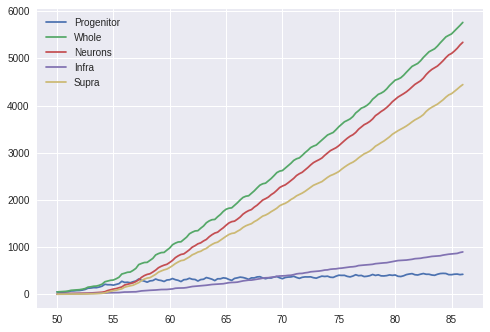

In [31]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

In [ ]:
show_curve(res.stats, REF.stats)

In [27]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 9908.452138594996 =======
G> G_0: b=1.82; m=3.00; theta=3.63; init=1.00; noise=1.00; expr=1.00; deg=0.10; asym=5.27; tree=(-0.08x0)
G> G_1: b=0.85; m=0.32; theta=4.86; init=1.38; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.81x0z AND 0.45x1 AND -0.56x3)
G> G_2: b=0.11; m=5.66; theta=8.00; init=0.48; noise=0.80; expr=1.00; deg=0.10; asym=5.00; tree=(0.10x0z AND -0.55x2 AND 0.64x0)
G> G_3: b=1.59; m=0.74; theta=6.89; init=0.73; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.25x1 AND 0.51x0z)
G> G_4: b=0.64; m=5.65; theta=4.98; init=0.67; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(-0.72x3 AND -0.23x4 AND 0.91x1)
G> G_5: b=0.83; m=8.69; theta=3.14; init=0.50; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(-0.65x3)
G> G_6: b=1.64; m=8.02; theta=8.48; init=1.71; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=()
R> tree=(0.78x6 OR 0.70x3)
R> tree=(0.32x1z OR -0.91x3 OR 0.16x5)
R> tree=(-0.02x1 OR 0.29x3)
R> tree=(-0.75x0 OR 0.70x7)
R> 

In [39]:
def metrics_bb_size(bb, ref, *args, **kwargs):
    d = O()
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    d.prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    d.neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    d.neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    d.prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    d.neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    d.neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    d.ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    d.ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    d.ref_neuron_supra_early = 0.0
    
    d.ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    d.ref_neuron_infra_late = d.ref_neuron_infra_early
    d.ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - d.ref_neuron_infra_late
    
    metrics = pd.DataFrame({
        "value": [d.prog_early, d.neuron_infra_early, d.neuron_supra_early,
                  d.prog_late, d.neuron_infra_late, d.neuron_supra_late],
        "ref": [d.ref_prog_early, d.ref_neuron_infra_early, d.ref_neuron_supra_early,
                d.ref_prog_late, d.ref_neuron_infra_late, d.ref_neuron_supra_late],
        "coeff": [0.5, 0.5, 0.5, 1, 1, 1],
    }, index=["prog_early", "neuron_infra_early", "neuron_supra_early",
                "prog_late", "neuron_infra_late", "neuron_supra_late"])
    
    metrics["metrics"] = (metrics["value"] - metrics["ref"]).apply(abs) * metrics["coeff"]
    
    return metrics

def score_metrics_bb_size(metrics):
    return 1 / max(1, 10000 - metrics["metrics"].sum())

In [40]:
metrics_bb_size(res, REF)

,value,ref,coeff,metrics
prog_early,5.897959,10.416462,0.5,2.259251
neuron_infra_early,4.285714,15.214988,0.5,5.464637
neuron_supra_early,22.163265,0.000000,0.5,11.081633
prog_late,8.612245,8.637592,1.0,0.025347
neuron_infra_late,18.285714,15.214988,1.0,3.070727
neuron_supra_late,90.693878,93.614251,1.0,2.920373
